In [1]:
import sys
import os
import time

import numpy as np
import scipy.ndimage
import pandas as pd
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import osr
from osgeo.gdalconst import *
driver = gdal.GetDriverByName('GTiff')
driver.Register()



2

In [2]:
def calculate_Qin_D8(Qin_array, Qout_array, direction):
    '''calculates Qin in each cell based on receiving Qout from neighboring cell(s)'''
    
    Qin_array += np.where(np.roll(direction, (-1,1), (1,0)) == 1,
                                      np.roll(Qout_array, (-1,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,1), (1,0)) == 2,
                                      np.roll(Qout_array, (0,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (1,1), (1,0)) == 3,
                                      np.roll(Qout_array, (1,1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (-1,0), (1,0)) == 4,
                                      np.roll(Qout_array, (-1,0), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,0), (1,0)) == 5,
                                      0,
                                      0) #5 is the outlet, must force discharge out
    Qin_array += np.where(np.roll(direction, (1,0), (1,0)) == 6,
                                      np.roll(Qout_array, (1,0), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (-1,-1), (1,0)) == 7,
                                      np.roll(Qout_array, (-1,-1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (0,-1), (1,0)) == 8,
                                      np.roll(Qout_array, (0,-1), (1,0)),
                                      0)
    Qin_array += np.where(np.roll(direction, (1,-1), (1,0)) == 9,
                                      np.roll(Qout_array, (1,-1), (1,0)),
                                      0)

In [3]:
def createRaster(filename, array, coords_system, resol, origin, nodata=-9999, dtype=GDT_Float32):
    '''creates a raster out of a 2D array of values'''
    print(filename)
    rows, cols = array.shape
    pixelWidth, pixelHeight = resol, resol
    originX = origin[0]
    originY = origin[1]
    
    ds = driver.Create(filename, cols, rows, 1, GDT_Float32)
    ds.SetGeoTransform((originX, pixelWidth, 0, originY, 0, -pixelHeight))
    band = ds.GetRasterBand(1)
    band.WriteArray(array)
    band.FlushCache()
    band.SetNoDataValue(-9999)
    ds.SetProjection(coords_system.ExportToWkt())
    
    ds = None

In [35]:
def applySMVE(deltaS, previous_H_array, previous_d, 
              psi_array, theta_array, K_array,
              deltatheta, eta, fi, resol):
    '''Takes in a water storage variation deltaS and redistributes it between the saturated (groundwater) and the unsaturated
    (soil moisture) parts of the aquifer. Applies Soil Moisture Velocity Equation (SMVE) with moisture (theta) bins.
    Returns the variation of the groundwater table (deltad), moisture quantity as height in each bin (current_H_array)
    and updated factor eta related to specific yield, which changes with groundwater table height (Sy = eta * fi)'''
    exit_condition = False
    rows, cols, num_bins = previous_H_array.shape
    error_tolerance = 0.02 * (fi * resol**2)
    error_prediction = np.full((rows, cols), error_tolerance + 1)
    previous_Vcapill_array = previous_H_array * deltatheta * resol**2
    previous_Vcapill = np.sum(previous_Vcapill_array, axis=2)
    previous_d_array = np.repeat(previous_d, num_bins).reshape(rows,cols,num_bins)
    working_psi_array = np.copy(psi_array)
    working_psi_array = np.where(np.less(D-previous_d_array-previous_H_array, 0.1),
                                 psi_b,
                                 working_psi_array)
    count = 0
    while exit_condition == False:
        count = 1
        print(count, eta[90:100, 90:100])
        deltad = deltaS / (eta * fi * resol**2)
        deltad = np.where(previous_d + deltad > D,
                          D - previous_d,
                          deltad)
        deltad = np.where(previous_d + deltad < 0,
                          -previous_d,
                          deltad)
        working_d = previous_d + deltad
        deltad_array = np.repeat(deltad, num_bins).reshape(rows,cols,num_bins)
        d_array = np.repeat(working_d, num_bins).reshape(rows,cols,num_bins)
        
        H_array = np.copy(previous_H_array)
        i_ = np.argmax(H_array, axis=2, out=np.empty((rows,cols), dtype='int64'))
        H_array[:,:,:] += deltad_array  #the level of every bin goes up or down the same quantity deltad, then readjust
        H_array = np.where(np.greater(d_array+H_array, D),
                           D-d_array,
                           H_array)
        K_array_i = K_array[np.repeat(np.arange(rows), cols),
                            np.repeat(np.arange(cols), rows, axis=0).flatten(),
                            i_.flatten()].reshape(rows, cols, 1)
        theta_array_i = theta_array[np.repeat(np.arange(rows), cols),
                                    np.repeat(np.arange(cols), rows, axis=0).flatten(),
                                    i_.flatten()].reshape(rows, cols, 1)

        working_H_array = H_array + (K_array - K_array_i)/(theta_array - theta_array_i)*(working_psi_array/H_array - 1)
        working_H_array = np.where(np.greater(d_array+working_H_array, D),
                                  D-d_array,
                                  working_H_array)
        working_H_array = np.where(np.less(working_H_array, 0),
                                  0,
                                  working_H_array)
        
        current_Vcapill_array = working_H_array * deltatheta * resol**2
        current_Vcapill = np.sum(current_Vcapill_array, axis=2)
        delta_Vcapill = current_Vcapill - previous_Vcapill
        predicted_deltaS = delta_Vcapill + deltad * (fi * resol**2)
        error_prediction = deltaS - predicted_deltaS
        if  np.all(abs(error_prediction) <= error_tolerance):
            exit_condition = True
        else:
            # means didn't add (remove) enough water, then have to increase eta
            eta += np.where(error_prediction < -error_tolerance,
                           np.minimum(abs(error_prediction)/error_tolerance, 0.05),
                           0)
                    # means we did add (remove) too much water, then have to decrease eta
            eta -= np.where(error_prediction > error_tolerance,
                           np.minimum(abs(error_prediction)/error_tolerance, 0.05),
                           0)
            # constrain eta to be a factor between 0 and 1 (actually 0.02 and 0.98)
            eta = np.where(eta >= 1,
                          0.98,
                          eta)
            eta = np.where (eta <= 0,
                           0.02,
                           eta) 
    current_H_array = -np.sort(-working_H_array)
    
    return deltad, current_H_array, eta 
    
            
        #elif np.all(abs(error_prediction)> error_tolerance):
        #if abs(error_prediction) <= error_tolerance:
        #    pass
        #elif (deltaS>0 and error_prediction > error_tolerance) or (deltaS<0 and error_prediction < error_tolerance)
        #    # means didn't add (remove) enough water, then have to increase eta
        #    eta += abs(error_prediction)/error_tolerance
        #elif (deltaS>0 and error_prediction < error_tolerance) or (deltaS<0 and error_prediction > error_tolerance):
        #    # means we did add (remove) too much water, then have to decrease eta
        #    eta -= abs(error_prediction)/error_tolerance


**drainTheWatershed** is the function simulating the drainage of the watershed. At the beginning od the simulation the soil, which has the same depth everywhere, is saturated. The groundwater table is at the ground surface everywhere.

During the simulation the groundwater travels through the soil down to the cell corresponding to outlet of the surface river network. By assumption, groundwater flowpath is the same as surface water.

As water moves down and groundwater table lowers, cells progressively become unsaturated, starting from source cells down to stream cells and lowlands. Cells are marked as saturated/unsat and corresponding areas are recorded. Water content in the soil, at watershed scale, is also recorded and related to saturated area. The relationship between these two values is charactertistic of the watershed (geometry, terrain morphology, type of soil) and mapped out to a file used later.




In [36]:
def drainTheWatershed(watershed_cells, elevationValues, tanbetaValues, lddValues, resol, structure, run_foldername,
                       originX, originY, outlet_cell, gauges_cells,
                       Area_ratio_list, normalized_Vsoilwater_list, saturFront_list,
                       waterSoilStorageValues, wTableHeightValues, 
                       total_area, saturatedWatershedSoilWaterVolume,
                       D, fi, Sy, Ks, m, psi_b, n_days, deltat=1, 
                       decaying_transmissivity=True):
    '''
    This function simulates the draining of the aquifer from a condition of complete saturation of the whole watershed.
    The purpose is to related ratio of saturated areas over total area AND water content in the soil of the watershed.
    Both quantities are calculated and recorded at each time step.
        
    ### Input parameters ###
    watershed_cells: array of cells that are part of the watershed (excludes all the NA, null value cells)
    elevationValues: array of elevation values of cells, i.e. DEM values
    tanbetaValues: array of local slope of each cell
    lddValues: flow direction according to D8 scheme
    gauge_cells: list of cells where values are printed out (x,y as in coordinate system, not array coords)
    Area_ratio_list: saturated area over total area at each time step
    normalized_Vsoilwater_list: water in the soil (storage) at each time step, normalized by saturatedWatershedSoilWaterVolume    
    waterSoilStorageValues: array of volumetric water content of cells, in saturated conditions (we don't count water in unsat)
    wTableHeightValues: array of thickness of groundwater table, measured from the bottom (bedrock/impervious)
    total_area: area of the watershed
    saturatedWatershedSoilWaterVolume: max possible water volume when all cells in the watershed are saturated
    D: thickness of aquifer in full saturated condition; i.e. distance of ground surface from bottom (bedrock/impervious)
    fi: porosity of soil
    Sy: specific yield, proportion of water that flows laterally after groundwater table lowers of a quantity deltad
    Ks: hydraulic conductivity in saturated conditions
    m: coefficient of transmissivity decay
    psi_b: bubbling pressure (0.1 meters)
    n_days: number of days of simulation
    deltat: length of time step, in hours
    decaying transmissivity: True if assumption that transimissivity decays exponentially with saturated layer thickness
    '''
    
    rows, cols = elevationValues.shape
    initial_storage = waterSoilStorageValues
    stopping_condition = False
    

    #rate of change of saturated cells slows in time, so we use longer time steps as the simulation goes on in time
    n_steps = 24 * n_days
    if n_days <= 30:
        n_steps = n_days*24
    elif n_days <= 90:
        n_steps = 30*24 + (n_days-30)*4
    elif n_days <= 180:
        n_steps = 30*24 + 60*4 + (n_days-90)*2
    elif n_days <= 360:
        n_steps = 30*24 + 60*4 + 90*2 + (n_days-180)*1
    else:
        n_steps = 30*24 + 60*4 + 90*2 + 180*1 + (n_days-360)//7 + (n_days-360)%7
    printout_steps = np.geomspace(1, n_steps+1, 20, dtype=int)
    
    #here we calculate theta and hydraulic conductivity K.
    #Values are fixed in each cell, because the number of bins is fixed, and K is function of theta.
    #psi also function of theta, and should be fixed, BUT cannot go above (below in abs value) the bubbling pressure
    n_vG = 2.25
    m_vG = 1 - 1/n_vG
    alfa_vG = 9 #m^-1, equivalent to 0.09 cm^-1
    num_bins = 8
    theta_values = np.linspace(0.05, 0.45, num=num_bins)
    deltatheta = theta_values[1] - theta_values[0]
    theta_array = np.zeros((rows, cols, num_bins))
    theta_array[:,:] = theta_values
    THETA_array = (theta_array-theta_array[0,0,0]) / (theta_array[0,0,-1]-theta_array[0,0,0])
    Kr_array = np.sqrt(THETA_array) * np.power(1 - np.power(1-np.power(THETA_array,1/m_vG), m_vG), 2)
    K_array = Kr_array * Ks
    psi_array = (1/alfa_vG) * np.power(np.power(1/THETA_array, 1/m_vG), 1/n_vG)
    
    # for state variables we use dictionaries, where key is the time step and value is the array of values in the watershed
    Qin_dict = {}
    Qout_dict = {}
    Q_dict={}
    S_dict = {}
    E_dict = {}
    d_dict = {}
    runoffVol_dict = {}
    psi_dict = {}
    eta_dict = {} # Sy = eta * fi; fi is constant, Sy and eta change with gw table depth (smallest near surface)
    H_dict = {}
    #psi is capillarity, function of theta, thetas are fixed, so psi are fixed too. Unless there is no capillarity,
    #then psi = psi_b, bubbling pressure, smaller pressure (in abs value, capillarity is negative, against gravity)
    
    
    current_time = 0
    previous_outlet_satur_index = 0
    previous_contiguous_saturated = np.where(watershed_cells==1, 1, watershed_cells)
    previous_front = 0
    
    Qin_dict[current_time] = np.zeros((rows, cols))
    Qout_dict[current_time] = np.zeros((rows, cols))
    S_dict[current_time] = waterSoilStorageValues
    E_dict[current_time] = elevationValues
    d_dict[current_time] = wTableHeightValues
    runoffVol_dict[current_time] = np.zeros((rows, cols))
    # fixed num of bins = 7 + 1 bin after theta_e, where psi=psi_b and H=0
    psi_dict[current_time] = np.full((rows, cols, num_bins), psi_b)  
    eta_dict[current_time] = np.full((rows, cols), Sy/fi)
    #theta_dict[current_time] = np.zeros((rows, cols, 7))
    H_dict[current_time] = np.zeros((rows, cols, num_bins)) # initialize H in each bin, cell
    
    # full saturation at the beginning, then max theta at each z, means last bin is full, then all bins are full
    H_dict[current_time][:,:,:] = 0.001
    
    current_time += deltat
    while current_time < n_steps*deltat and stopping_condition == False:
        print("current time step: {}".format(current_time))
        
        # initialize cells to 0 for each status variable, just a way to set the size of arrays
        Qin_dict[current_time] = np.zeros((rows, cols))
        Qout_dict[current_time] = np.zeros((rows, cols))
        S_dict[current_time] = np.zeros((rows, cols))
        E_dict[current_time] = np.zeros((rows, cols))
        d_dict[current_time] = np.zeros((rows, cols))
        runoffVol_dict[current_time] = np.zeros((rows, cols))
        H_dict[current_time] = np.zeros((rows, cols, num_bins)) 
        
    
        previous_d = d_dict[current_time-deltat]
        previous_H_array = H_dict[current_time-deltat]
        eta = eta_dict[current_time-deltat]
        #T = K_array * previous_H
        T = Ks * previous_d
                
        if decaying_transmissivity == True:
            T = np.where(previous_d < (D - psi_b),
                         (Ks*D) * np.exp(-1*(D-psi_b-previous_d)*(eta*fi)/m),
                         T)

        # (actually no) need to transpose tanbetaValues to account for third dimension (theta bins). See below
        print(type(T), type(resol), type(tanbetaValues))
        print(T.shape, tanbetaValues.shape)
        print(resol)
        Qout = T * tanbetaValues * resol
        Qout_dict[current_time] = Qout
        direction = lddValues
        calculate_Qin_D8(Qin_dict[current_time], Qout_dict[current_time], direction)
        Qin = Qin_dict[current_time]

        #calculate current storage. Storage cannot be more than saturated condition and cannot be < 0
        deltaS = (Qin - Qout) * deltat
        #no_deltaS = np.where(deltaS == 0, 1, 0)
        previous_S = S_dict[current_time - deltat]
        runoffVol = np.where(np.greater(previous_S + deltaS, initial_storage),
                            (previous_S + deltaS - initial_storage)/deltat,
                            0)
        deltaS -= runoffVol
        deltaS = np.where(np.less(previous_S + deltaS, 0),
                         - previous_S,
                         deltaS)
        S = previous_S + deltaS
        S_dict[current_time] = S
        
        #calculate current thickness of saturated layer. Cannot be more than D=dmax and cannot be < 0
        # here is where we redistribute the moisture and find the actual d of the groundwater table
        deltad, current_H_array, eta = applySMVE(deltaS, previous_H_array, previous_d, 
                                                 psi_array, theta_array, K_array,
                                                 deltatheta, eta, fi, resol)

        d = previous_d + deltad
        #sy_dict[d] = eta*fi 
        d_dict[current_time] = d
        #commented line below are actually taken care in the applySMVE function already
        #d = np.where(d > D,
        #             D, 
        #             d)
        #d = np.where(d < 0, #previous_d + deltad < 0,
        #             0, 
        #             d)
        
        H_dict[current_time] = current_H_array
        eta_dict[current_time] = eta
        # if we want to recalculate the actual storage based on the actual d (saturated) and Hs in bins (unsaturated)
        #current_Vcapill_array = current_H_array * deltatheta * resol**2
        #current_Vcapill = np.sum(current_Vcapill_array, axis=2)
        #S = current_Vcapill + (fi * d * resol**2)
        #S_dict[current_time] = S
        
        
        #saturated area contributing to runoff to outlet
        saturated_cells = np.where(d>0.0, 0, d)
        saturated_cells = np.where(d >= (D-psi_b), 1, saturated_cells)
        contiguous_saturated = scipy.ndimage.label(saturated_cells, structure)[0]
        if current_time in [-1]:#10,20,50,100,150,200,250,300]:
            createRaster(run_foldername+watershed_nick+"_S_{}.tif".format(current_time),
                         S, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_d_{}.tif".format(current_time),
                         d, coords_system, resol, [originX, originY])
            createRaster(run_foldername + watershed_nick + "_{}_saturated_cells.tif".format(current_time), 
                         saturated_cells, coords_system, resol, [originX, originY])
            
        
        outlet_satur_index = contiguous_saturated[outlet_cell[0]][outlet_cell[1]]
        #print(outlet_satur_index, outlet_cell[0], outlet_cell[1])
        if outlet_satur_index > 0:
            contiguous_saturated = np.where(d>0.0, contiguous_saturated, 0)
            contiguous_saturated = np.where(contiguous_saturated == outlet_satur_index, 1, 0)
            if current_time in printout_steps:#10,20,50,100,150,200,250,300]:
                createRaster(run_foldername + watershed_nick + "_{}_contiguous_saturated.tif".format(current_time), 
                             contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
        else:
            print("\n\nWARNING: the outlet turned unsaturated at time step {}.".format(current_time))
            contiguous_saturated = np.where(d>0.0, contiguous_saturated, 0)
            contiguous_saturated = np.where(contiguous_saturated > outlet_satur_index, 1, 0)
            createRaster(result_dir + watershed_nick + "_{}_end_contiguous_saturated.tif".format(current_time), 
                         contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
            stopping_condition = True
        
        
        #calculate saturated area in watershed, cells where groundwater table not below bubbling pressure distance 
        #from ground surface
        saturated_area = np.sum(contiguous_saturated) * resol * resol
        #print(current_time, saturated_area)
        area_ratio = saturated_area/total_area
        Area_ratio_list.append(area_ratio)
        
        # calculate sum of water content in soil for all cells, saturated and non-saturated
        watershed_soilStorage = np.where(watershed_cells==1, S, 0)
        watershedSoilWaterVolume = np.sum(watershed_soilStorage)
        normalized_Vsoilwater_list.append(watershedSoilWaterVolume/saturatedWatershedSoilWaterVolume)
        watershed_soilStorage = np.where(watershed_cells==1, S, None)
        
        #calculate front of saturated area
        #current_front = updateFront(previous_contiguous_saturated, contiguous_saturated, previous_front, d, current_time)
        #saturated_front = 0
        #saturated_front += np.sum(contiguous_saturated[:,1:] != contiguous_saturated[:,:-1])
        #saturated_front += np.sum(contiguous_saturated[1:,:] != contiguous_saturated[:-1,:])
        #saturated_front += np.sum(contiguous_saturated[0,:] == 1) + np.sum(contiguous_saturated[-1,:] == 1)
        #saturated_front += np.sum(contiguous_saturated[:,0] == 1) + np.sum(contiguous_saturated[:,-1] == 1)
        #saturFront_list.append(current_front*resol)
        #previous_contiguous_saturated = contiguous_saturated
        #previous_front = current_front


        #for gauge in gauges_cells:
            #print("At {} water table height (d) is : {}".format(gauge, d_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} water elevation is : {} m asl".format(gauge, E_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} water storage (S) is : {}".format(gauge, S_dict[current_time][gauge[0]][gauge[1]]))
            #print("At {} runoff is {} m^3\n".format(gauge, runoffVol_dict[current_time][gauge[0]][gauge[1]]))
        
        
        Qin_dict[current_time-deltat] = None
        Qout_dict[current_time-deltat] = None
        d_dict[current_time-deltat] = None
        S_dict[current_time-deltat] = None
        E_dict[current_time-deltat] = None
        runoffVol_dict[current_time-deltat] = None
        H_dict[current_time-deltat] = None
        eta_dict[current_time-deltat] = None
        
        if current_time in [-665,-666]:
            #filename = data_dir+watershed_nick+"_saturated_{}.tif".format(current_time)
            
            createRaster(run_foldername+watershed_nick+"_Qin_{}.tif".format(current_time),
                         Qin, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_Qout_{}.tif".format(current_time),
                         Qout, coords_system, resol, [originX, originY])
            createRaster(run_foldername+watershed_nick+"_contiguous_saturated_{}.tif".format(current_time),
                         contiguous_saturated, coords_system, resol, [originX, originY], nodata=0)
            
        
        if current_time > 30*24:
            deltat = 6
        elif current_time > 30*24+60*4:
            deltat = 12
        elif current_time > 30*24+60*4+90*12:
            deltat = 24
        elif current_time > 30*24+60*4+90*12+180*1:
            deltat = 24*7
        
        current_time += deltat
    
    createRaster(run_foldername+watershed_nick+"_saturated.tif", 
                     saturated_cells, coords_system, resol, [originX, originY])
    createRaster(run_foldername+watershed_nick+"_d_end.tif", 
                     d, coords_system, resol, [originX, originY])
    createRaster(run_foldername+watershed_nick+"_S_end.tif", 
                     S, coords_system, resol, [originX, originY])
    
    for i in range(saturated_cells.shape[0]):
        for j in range(saturated_cells.shape[1]):
            if saturated_cells[i][j] == 1:
                x = originX + resol*j
                y = originY - resol*i
                #print(i,j,x,y)


    
    
def print_Aratio_SoilWatVol_relationship(filename, Area_ratio_list,normalized_Vsoilwater_list,saturFront_list):
    '''
    The function prints out the curve (corresponding values) to a txt file (filename).
    The curve can thus be reused later to estimate saturated excess contributing areas given 
    a certain amount of water in the soil
    '''
    relationship_df = pd.DataFrame({"AreaRatio": Area_ratio_list,
                                  "norm_SoilWatVol": normalized_Vsoilwater_list})
                                    #,
                                   #"Saturated_Front": saturFront_list})
    relationship_df.to_csv(filename, sep='\t')


In [37]:
def plotCurve(normalized_Vsoilwater_list, Area_ratio_list, saturFront_list,
              run_folder, watershed_name, watershed_nick,
              decaying_transmissivity, m):
    #plot the curve (saturated area ratio vs normalized soil water content) and save as jpg

    fig,ax = plt.subplots(figsize=(10,5.5))
    ax.set_title(watershed_name + ' - Saturated area ratio vs Soil water content', fontsize=20)
    ax.set_ylabel(r'$\frac{A_{sat}}{A_{tot}}$', fontsize=22, labelpad=22, rotation='horizontal')
    ax.set_xlabel("Normalized soil water content", fontsize=16, labelpad=0, rotation='horizontal')
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=13)

    spaced_xticks = [min(normalized_Vsoilwater_list),
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.25,
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.5,
                     min(normalized_Vsoilwater_list)+(max(normalized_Vsoilwater_list)-min(normalized_Vsoilwater_list))*0.75,
                     max(normalized_Vsoilwater_list)]
    #spaced_xticks = [0.0, 0.25, 0.5, 0.75, 1.0]
    print(spaced_xticks)
    ax.set_xticks(spaced_xticks)
    ax.set_xticklabels(['{0:.2f}'.format(spaced_xticks[0])+"\nNo area saturated",
                        '{0:.2f}'.format(spaced_xticks[1]),
                        '{0:.2f}'.format(spaced_xticks[2]),
                        '{0:.2f}'.format(spaced_xticks[3]),
                        '{0:.2f}'.format(spaced_xticks[-1])+"\nAll areas saturated"], 
                       fontsize=13)

    ax.plot(normalized_Vsoilwater_list, Area_ratio_list, color='k', linewidth=3)

    if decaying_transmissivity == False:
        plt.gcf().text(0.15, 0.8, "No transmissivity decay", 
                       fontsize=14, color='blue', fontweight="bold")
        fig.show()
        plt.savefig(run_folder + watershed_nick + "_satAreaRatio_SoilWaterVol_noDecay.jpg".format(m), dpi=85)
    else:
        plt.gcf().text(0.15, 0.8, "decay transmissivity\nparameter m = {}".format(m), 
                       fontsize=14, color='blue', fontweight="bold")
        fig.show()
        plt.savefig(run_folder + watershed_nick + "_satAreaRatio_SoilWaterVol_Decay_{}.jpg".format(m), dpi=85)

        

In [38]:
dir_path = os.path.realpath('./')
cwd = os.getcwd()

#################################### change watershed names/folders to area of interest! #########################
global watershed_name, watershed_foldername, watershed_nick, data_dir, result_dir, coords_system
watershed_name = "Hubbard #7"
watershed_foldername = "hubbard_brook"
watershed_nick = "hub7"
data_dir = (os.path.abspath(os.path.join(dir_path,'..')) + "/data/" + 
               watershed_foldername + os.path.sep +
               watershed_nick + os.path.sep)
result_dir = (os.path.abspath(os.path.join(dir_path,'..')) + "/model_results/" + 
               watershed_foldername + os.path.sep +
               watershed_nick + os.path.sep)
dem = data_dir + watershed_nick + "_10dem.tif"
tanbeta = data_dir + watershed_nick + "_tanbeta.tif"
ldd = data_dir + watershed_nick + "_ldd.tif"

################################### soil parameters ##############################################################
D = 2  #thickness of unconfined aquifer, shallow groundwater

#parameters for sandy loam  
Ks = 20  #micrometers per second
Ks = Ks * 3600 / 1000000  #meters per hour
decaying_transmissivity = False
m = 0.1  #this should be big number, so the exponent go to 0 (really? How big?)
psi_b = 0.1  #bubbling pressure / capillary head, for sand
fi = 0.45  #porosity
Sy = 0.24  #specific yield

################################# simulation run parameters ######################################################
n_days = 20000  #length of simulation
deltat = 1  #timestep
run_number = 11
outlet_coords = [759560, 4868910] #array of points, one point (x,y) for each row, where to record values
gauges_coords = [[759560, 4868910]] #array of points, one point (x,y) for each row, where to record values
#gauges_coords = [[277914.8, 4867532.8]] #array of points, one point (x,y) for each row, where to record values


elevations_ds = gdal.Open(dem, GA_ReadOnly)
band = elevations_ds.GetRasterBand(1)
cols = elevations_ds.RasterXSize
rows = elevations_ds.RasterYSize
print(rows, cols)
elevationValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
elevationValues = np.ma.masked_equal(elevationValues, nodata)
geotransform = elevations_ds.GetGeoTransform()
originX = geotransform[0]
originY = geotransform[3]
raster_origin = [originX, originY]
resol = np.round(geotransform[1])
print(originX, originY, resol)
#coords_system = osr.SpatialReference()
#coords_system.ImportFromEPSG(26919)
prj = elevations_ds.GetProjection()
coords_system = osr.SpatialReference(wkt=prj)
#proj_coords_system_string = srs.GetAttrValue('projcs')
#geog_coords_system_string = srs.GetAttrValue('geogcs')

tanbeta_ds = gdal.Open(tanbeta, GA_ReadOnly)
band = tanbeta_ds.GetRasterBand(1)
tanbetaValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
tanbetaValues = np.ma.masked_equal(tanbetaValues, nodata)
tanbetaValues = np.where(tanbetaValues == 0, 0.01, tanbetaValues)
#tanbetaValues = ma.masked_less(tanbetaValues, 0)


ldd_ds = gdal.Open(ldd, GA_ReadOnly)
band = ldd_ds.GetRasterBand(1)
lddValues = band.ReadAsArray(0, 0, cols, rows)
nodata = band.GetNoDataValue()
lddValues = np.ma.masked_equal(lddValues, nodata)
#lddValues = ma.masked_less(lddValues, 0)
ldd_dict = {1: [1, -1],
            2: [1, 0],
            3: [1, 1],
            4: [0, -1],
            5: [0, 0],
            6: [0, 1],
            7: [-1, -1],
            8: [-1, 0],
            9: [-1, 1]    
}
structure = [[1,1,1],
             [1,1,1],
             [1,1,1]]
    
#initialize to all cells saturated
waterStorageFile = data_dir + watershed_nick + "_storage.tif"
initial_storage = D*resol*resol*fi
waterStorageArray = np.where(elevationValues>0.0, initial_storage, None)
createRaster(waterStorageFile, waterStorageArray, coords_system, resol, raster_origin)
waterStorage_ds = gdal.Open(waterStorageFile, GA_ReadOnly)
waterStorage_geotransform = waterStorage_ds.GetGeoTransform()
#print(waterStorage_geotransform[0], waterStorage_geotransform[3], resol)
band = waterStorage_ds.GetRasterBand(1)
waterSoilStorageValues = band.ReadAsArray(0, 0, cols, rows)
saturatedWatershedWaterVolume = np.sum(waterSoilStorageValues)

wTableHeightFile = data_dir + watershed_nick + "_water_table_height.tif"
wTableHeightArray = np.where(elevationValues>0.0, D, None)
createRaster(wTableHeightFile, wTableHeightArray, coords_system, resol, raster_origin)
wTableHeight_ds = gdal.Open(wTableHeightFile, GA_ReadOnly)
tableHeight_geotransform = wTableHeight_ds.GetGeoTransform()
#print(tableHeight_geotransform[0], tableHeight_geotransform[3], resol)
band = wTableHeight_ds.GetRasterBand(1)
wTableHeightValues = band.ReadAsArray(0, 0, cols, rows)

# these lists contain the values to build the area ratio vs soil content curve
Area_ratio_list = []
normalized_Vsoilwater_list = []
saturFront_list = []
watershed_cells = np.where(elevationValues>0.0, 1, 0)
#createRaster(data_dir + watershed_nick + "_watershed_cells.tif", watershed_cells, coords_system, resol, raster_origin)
total_area = np.sum(watershed_cells) * resol * resol
watershed_cells = np.where(elevationValues>0.0, 1, None)
saturatedWatershedSoilStorage = np.where(watershed_cells==1, waterSoilStorageValues, 0)
saturatedWatershedSoilWaterVolume = np.sum(saturatedWatershedSoilStorage)


outlet_cell = list([-int((outlet_coords[1] - originY) / resol), int((outlet_coords[0] - originX) / resol)])
gauges_cells = []
for point in gauges_coords:
    gauges_cells.append([-int((point[1] - originY) / resol), int((point[0] - originX) / resol)])
print(gauges_coords, gauges_cells)


run_foldername = "{}_{}_{}".format(watershed_nick, n_days, run_number, m) + os.path.sep
if decaying_transmissivity == True:
    run_foldername = "{}_{}_{}_decay{}".format(watershed_nick, n_days, run_number, m) + os.path.sep
if not os.path.exists(run_foldername):
    os.mkdir(run_foldername)
#print(run_foldername)


start_time = time.perf_counter()
drainTheWatershed(watershed_cells, elevationValues, tanbetaValues, lddValues, resol, structure, run_foldername,
                   originX, originY, outlet_cell, gauges_cells,
                   Area_ratio_list, normalized_Vsoilwater_list, saturFront_list,
                   waterSoilStorageValues, wTableHeightValues,
                   total_area, saturatedWatershedSoilWaterVolume,
                   D, fi, Sy, Ks, m, psi_b, n_days, deltat,
                   decaying_transmissivity)
if decaying_transmissivity == True:
    relationship_table_filename = run_foldername+watershed_nick+"_{}_{}_decay{}_ARatio_satFront_SoilWatVol.txt".format(n_days, run_number, m)
else:
    relationship_table_filename = run_foldername+watershed_nick+"_{}_{}_noDecay_ARatio_satFront_SoilWatVol.txt".format(n_days, run_number)
print_Aratio_SoilWatVol_relationship(relationship_table_filename,
                                     Area_ratio_list,
                                     normalized_Vsoilwater_list,
                                    saturFront_list)
print("\nSaturated area ratio at the end of the simulation is {}%.".format(100 * Area_ratio_list[-1]))
print("The model ran {} days in {} seconds in {} watershed.".format(n_days, 
                                                                    (time.perf_counter() - start_time),
                                                                    watershed_name))
    
plotCurve(normalized_Vsoilwater_list, Area_ratio_list, saturFront_list,
          run_foldername, watershed_name, watershed_nick,
          decaying_transmissivity, m)


#main()
#if __name__ == __main__:
#    main()

129 118
759080.0 4868920.0 10.0
C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/hubbard_brook\hub7\hub7_storage.tif
C:\Users\feder\Documents\CUAHSI\repos\Aquaholics_Anonymous/data/hubbard_brook\hub7\hub7_water_table_height.tif
[[759560, 4868910]] [[1, 48]]
current time step: 1


C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in greater
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in less
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
C:\Users\feder\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_d

<class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.ndarray'>
(129, 118) (129, 118)
10.0
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

  0.53333333 0.53333333 0.53333333 0.53333333]]
1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.5333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

1 [[0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.53333333 0.53333333 0.53333333 0.53333333]
 [0.53333333 0.53333333 0.53333333 0.53333333 0.53333333 0.53333333
  0.533333

KeyboardInterrupt: 

In [ ]:
################################ SANDBOX ONLY BELOW  ################################
a = np.array([[0,1,1,0],[1,1,1,1],[0,0,1,0],[1,0,1,0]])
print(a)
print(np.roll(a,(0,-1),(1,0)))

[0.05       0.11666667 0.18333333 0.25       0.31666667 0.38333333
 0.45      ]
[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]
[0.00000000e+00 2.02685519e-04 3.64299784e-03 2.07830416e-02
 7.65008423e-02 2.34845128e-01 1.00000000e+00]


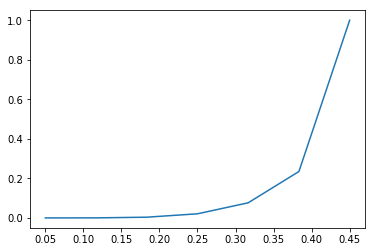

In [9]:
Ks = 20*3600/1000000
n_K = 2.25
m_K = 1 - 1/n_K
theta_array = np.linspace(0.05, 0.45, num=7)
THETA_array = (theta_array-theta_array[0]) / (theta_array[-1]-theta_array[0])
Kr_array = np.sqrt(THETA_array) * np.power(1 - np.power(1-np.power(THETA_array,1/m_K), m_K), 2)
K_array = Kr_array * Ks
print(theta_array)
print(THETA_array)
print(Kr_array)
plt.plot(theta_array, Kr_array)

In [10]:
tanbetavalues = np.array([[0.3,0.2,0.05],
                          [0.5, 0.4, 0.08]])
print(tanbetavalues.shape)
tanb = np.broadcast_to(tanbetavalues, (7,)+tanbetavalues.shape)
tanb = np.transpose(tanb,axes=(1,2,0))
tanbeta = np.copy(tanb)
print(tanbeta)
#tanbetavalues = np.tile(np.transpose(tanbetavalues),(1,3,7))
Hs = np.zeros((2, 3, 7))
Hs[:,:,:] = 3
Hs[0,2,:] = 1.5
T = K_array * Hs


tanbeta[:,:,-1] += 10.0
print(tanbeta)
print()
print(Hs)
print(K_array)
print(T)
print("ciao")
print(T*5*tanbeta)

(2, 3)
[[[0.3  0.3  0.3  0.3  0.3  0.3  0.3 ]
  [0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
  [0.05 0.05 0.05 0.05 0.05 0.05 0.05]]

 [[0.5  0.5  0.5  0.5  0.5  0.5  0.5 ]
  [0.4  0.4  0.4  0.4  0.4  0.4  0.4 ]
  [0.08 0.08 0.08 0.08 0.08 0.08 0.08]]]
[[[ 0.3   0.3   0.3   0.3   0.3   0.3  10.3 ]
  [ 0.2   0.2   0.2   0.2   0.2   0.2  10.2 ]
  [ 0.05  0.05  0.05  0.05  0.05  0.05 10.05]]

 [[ 0.5   0.5   0.5   0.5   0.5   0.5  10.5 ]
  [ 0.4   0.4   0.4   0.4   0.4   0.4  10.4 ]
  [ 0.08  0.08  0.08  0.08  0.08  0.08 10.08]]]

[[[3.  3.  3.  3.  3.  3.  3. ]
  [3.  3.  3.  3.  3.  3.  3. ]
  [1.5 1.5 1.5 1.5 1.5 1.5 1.5]]

 [[3.  3.  3.  3.  3.  3.  3. ]
  [3.  3.  3.  3.  3.  3.  3. ]
  [3.  3.  3.  3.  3.  3.  3. ]]]
[0.00000000e+00 1.45933573e-05 2.62295845e-04 1.49637899e-03
 5.50806064e-03 1.69088492e-02 7.20000000e-02]
[[[0.00000000e+00 4.37800720e-05 7.86887534e-04 4.48913698e-03
   1.65241819e-02 5.07265477e-02 2.16000000e-01]
  [0.00000000e+00 4.37800720e-05 7.86887534e-04 4.48913698

In [11]:
a = np.zeros((2,3,6))
rows, cols = a.shape[0], a.shape[1]

b_arr = [1, 0.9, 0.8, 0.65, 0.5, 0.25]
c_arr = [1.2, 1.2, 1.2, 0.8, 0.9, 0.4]
a[:,:1] = b_arr
a[:,1:] = c_arr
print(a)
#b = np.empty((2,3), dtype='int64')
a_search = np.where(a<=1, a, -1)
print("a_search", a_search)
b = np.argmax(a_search, axis=-1, out=np.empty((2,3), dtype='int64'))-1
b = np.where(b<0, 0, b)
THETA_array = (a-a[0,0,0]) / (a[0,0,-1]-a[0,0,0])
print(THETA_array)
Kr_array = np.sqrt(THETA_array) * np.power(1 - np.power(1-np.power(THETA_array,1/m_K), m_K), 2)
print(Kr_array)
print("b\n",b)
b.reshape((2,3,1))
print(b.shape)
new_h = a[np.repeat([0,1], a.shape[1]), np.repeat([[0,1,2]], a.shape[0], axis=0).flatten(), b.flatten()].reshape(rows, cols, 1)
print(new_h)
#new_h = a[np.broadcast_to(np.arange(b.shape[0]), (2,3)),
#          np.broadcast_to(np.arange(b.shape[1]), (2,3)),
#          b]
a - new_h

[[[1.   0.9  0.8  0.65 0.5  0.25]
  [1.2  1.2  1.2  0.8  0.9  0.4 ]
  [1.2  1.2  1.2  0.8  0.9  0.4 ]]

 [[1.   0.9  0.8  0.65 0.5  0.25]
  [1.2  1.2  1.2  0.8  0.9  0.4 ]
  [1.2  1.2  1.2  0.8  0.9  0.4 ]]]
a_search [[[ 1.    0.9   0.8   0.65  0.5   0.25]
  [-1.   -1.   -1.    0.8   0.9   0.4 ]
  [-1.   -1.   -1.    0.8   0.9   0.4 ]]

 [[ 1.    0.9   0.8   0.65  0.5   0.25]
  [-1.   -1.   -1.    0.8   0.9   0.4 ]
  [-1.   -1.   -1.    0.8   0.9   0.4 ]]]
[[[-0.          0.13333333  0.26666667  0.46666667  0.66666667
    1.        ]
  [-0.26666667 -0.26666667 -0.26666667  0.26666667  0.13333333
    0.8       ]
  [-0.26666667 -0.26666667 -0.26666667  0.26666667  0.13333333
    0.8       ]]

 [[-0.          0.13333333  0.26666667  0.46666667  0.66666667
    1.        ]
  [-0.26666667 -0.26666667 -0.26666667  0.26666667  0.13333333
    0.8       ]
  [-0.26666667 -0.26666667 -0.26666667  0.26666667  0.13333333
    0.8       ]]]
[[[-0.00000000e+00  8.07029795e-05  1.42709383e-03  1.5371279

C:\Users\antolini\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
C:\Users\antolini\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()


array([[[ 0.  , -0.1 , -0.2 , -0.35, -0.5 , -0.75],
        [ 0.4 ,  0.4 ,  0.4 ,  0.  ,  0.1 , -0.4 ],
        [ 0.4 ,  0.4 ,  0.4 ,  0.  ,  0.1 , -0.4 ]],

       [[ 0.  , -0.1 , -0.2 , -0.35, -0.5 , -0.75],
        [ 0.4 ,  0.4 ,  0.4 ,  0.  ,  0.1 , -0.4 ],
        [ 0.4 ,  0.4 ,  0.4 ,  0.  ,  0.1 , -0.4 ]]])

In [1]:
print(a)
print(-np.sort(-a))
d = np.array([[1.5, 1, 1], [1.5, 1, 1]])
d_array = np.repeat(d, 6).reshape(2,3,6)
10 - d_array - a

NameError: name 'a' is not defined

In [ ]:
b = np.array([[0,0,1,1,0],[1,1,1,1,0],[1,1,1,0,1],[1,1,0,0,0],[1,1,1,0,1]])
c = np.array([[0,0,1,1,0],[1,1,1,1,0],[0,0,1,0,0],[1,0,0,0,0],[1,1,1,0,1]])
print(b)
print()
print(c)
print('\n')
structure = [[1,1,1],
             [1,1,1],
             [1,1,1]]
contiguous_saturated = scipy.ndimage.label(c, structure)[0]
contiguous_saturated = np.where(contiguous_saturated == 1, 1, 0)
previous_contiguous_saturated = scipy.ndimage.label(b, structure)[0]
previous_contiguous_saturated = np.where(previous_contiguous_saturated == 1, 1, 0)
print(previous_contiguous_saturated)
print()
print(contiguous_saturated)
previous_perimeter = 0
previous_perimeter += np.sum(previous_contiguous_saturated[:,1:] != previous_contiguous_saturated[:,:-1])
previous_perimeter += np.sum(previous_contiguous_saturated[1:,:] != previous_contiguous_saturated[:-1,:])

contiguous_saturated, previous_contiguous_saturated
#satur_to_nonsatur = np.where(contiguous_saturated != previous_contiguous_saturated, 200, None)
satur_to_nonsatur_only = np.where(contiguous_saturated != previous_contiguous_saturated, 1, None)
print(satur_to_nonsatur_only)
satur_to_nonsatur_for_perimeter = np.where(contiguous_saturated != previous_contiguous_saturated, 200, contiguous_saturated)
satur_to_nonsatur_only_rows, satur_to_nonsatur_only_cols = satur_to_nonsatur_only.shape
print(satur_to_nonsatur_for_perimeter)
print()
current_perimeter = previous_perimeter
for i in range(satur_to_nonsatur_only_rows):
    for j in range(satur_to_nonsatur_only_cols):
        if satur_to_nonsatur_for_perimeter[i][j] != 200:
            continue

        neighborhood = []

        if j==0:
            west = None
        else:
            west = satur_to_nonsatur_for_perimeter[i][j-1]
        neighborhood.append(west)

        if i==0:
            north = None
        else:
            north = satur_to_nonsatur_for_perimeter[i-1][j]
        neighborhood.append(north)

        try:
            east = satur_to_nonsatur_for_perimeter[i][j+1]
        except:
            east = None
        neighborhood.append(east)

        try:
            south = satur_to_nonsatur_for_perimeter[i+1][j]
        except:
            south = None
        neighborhood.append(south)

        print(i, j, neighborhood)
        for neighbor in neighborhood:
            if neighbor == 0:
                current_perimeter -= 1
            if neighbor == 1:
                current_perimeter += 1
print(current_perimeter)        


In [ ]:
#currently not used
def setCellsCoords(rows, cols):
    '''creates an array pf values, value is coordinates pair'''
    coords = np.empty((rows,cols),dtype=str)
    for i in range(rows):
        for j in range(cols):
            coords[i][j] = str(int(i))+'.'+str(int(j))
    return coords



def prepareOutputFile(infile, coords):
    rows, cols = coords.shape
    infile.write("Timestep\t")
    for i in range(rows):
        for j in range(cols):
            infile.write(coords[i][j])
            infile.write("\t")
    infile.write("\n")
    return infile



def writeLineOutputFile(infile,timestep,values):
    rows, cols = values.shape
    infile.write("{}\t".format(timestep))
    for i in range(rows):
        for j in range(cols):
            infile.write("{0:.3f}\t".format(values[i][j]))
    infile.write("\n")
    return infile



def updateFront(previous_contiguous_saturated, contiguous_saturated, previous_front, d, current_time):
    frontwise_previous_contiguous_saturated = np.where(d>0.0, previous_contiguous_saturated, -200)
    frontwise_contiguous_saturated = np.where(d>0.0, contiguous_saturated, -200)
    satur_to_nonsatur_only = np.where(frontwise_contiguous_saturated != frontwise_previous_contiguous_saturated, 1, None)
    #print(satur_to_nonsatur_only)
    satur_to_nonsatur_for_front = np.where(frontwise_contiguous_saturated != frontwise_previous_contiguous_saturated, 200, frontwise_contiguous_saturated)
    satur_to_nonsatur_only_rows, satur_to_nonsatur_only_cols = satur_to_nonsatur_only.shape
    #print(satur_to_nonsatur_only.shape, satur_to_nonsatur_for_front.shape)
    #print()
    current_front = previous_front
    for i in range(satur_to_nonsatur_only_rows):
        for j in range(satur_to_nonsatur_only_cols):
            if satur_to_nonsatur_for_front[i][j] != 200:
                continue

            neighborhood = []

            if j==0:
                west = None
            elif frontwise_contiguous_saturated[i][j-1] == -200:
                west = None
            else:
                west = satur_to_nonsatur_for_front[i][j-1]
            neighborhood.append(west)

            if i==0:
                north = None
            elif frontwise_contiguous_saturated[i-1][j] == -200:
                north = None
            else:
                north = satur_to_nonsatur_for_front[i-1][j]
            neighborhood.append(north)

            try:
                east = satur_to_nonsatur_for_front[i][j+1]
                if frontwise_contiguous_saturated[i][j+1] == -200:
                    east = None
            except:
                east = None  
            neighborhood.append(east)

            try:
                south = satur_to_nonsatur_for_front[i+1][j]
                if frontwise_contiguous_saturated[i+1][j] == -200:
                    south = None
            except:
                south = None
            neighborhood.append(south)

            #print(i, j, neighborhood)
            for neighbor in neighborhood:
                if neighbor == 0:
                    current_front -= 1
                if neighbor == 1:
                    current_front += 1
    #print(current_time, current_front)
    return current_front



